## This script compares the outputs from MiDaS Monocular Depth Estimation models
- This compares the `.onnx` files not `.pt` files. For PyTorch files see [compare.py](./compare.py)
- The MiDaS v3/v3.1 onnx files are from [this fork](https://github.com/parkchamchi/MiDaS), see [this notebook](https://github.com/parkchamchi/MiDaS/blob/master/DIFFTEST.ipynb) for comparing `.onnx` and `.pt` outputs
- This script assumes that this files are in `../../onnx`:
  - dpt_beit_large_512.onnx
  - dpt_swin2_large_384.onnx
  - dpt_large_384.onnx
  - dpt_hybrid_384.onnx
  - model-f6b98070.onnx
  - model-small.onnx

In [1]:
basenames = [
	"dpt_beit_large_512",
	"dpt_swin2_large_384",
	"dpt_large_384",
	"dpt_hybrid_384",
	"model-f6b98070",
	"model-small",
]

In [2]:
onnxdir = "../../onnx"

import os
onnx_files = [filename.replace(".onnx", "") for filename in os.listdir(onnxdir) if filename.endswith(".onnx")]
onnx_files

['dpt_beit_large_512',
 'dpt_hybrid_384',
 'dpt_large_384',
 'dpt_swin2_large_384',
 'model-f6b98070',
 'model-small']

In [3]:
assert set(onnx_files) >= set(basenames)

In [4]:
import sys
sys.path.append("..")

from midas.transforms import Resize, NormalizeImage, PrepareForNet

from torchvision.transforms import Compose
import cv2

def get_transform(modelname, net_w, net_h):
	if "v2.1" not in modelname:
		#From model_loader.py
		transform = Compose(
			[
				Resize(
					net_w,
					net_h,
					resize_target=None,
					keep_aspect_ratio=False,
					ensure_multiple_of=32,
					resize_method="minimal",
					image_interpolation_method=cv2.INTER_CUBIC,
				),
				NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
				PrepareForNet(),
			]
		)

	else:
		#From run_onnx.py

		def compose2(f1, f2):
			return lambda x: f2(f1(x))

		resize_image = Resize(
			net_w,
			net_h,
			resize_target=None,
			keep_aspect_ratio=False,
			ensure_multiple_of=32,
			resize_method="upper_bound",
			image_interpolation_method=cv2.INTER_CUBIC,
		)

		transform = compose2(resize_image, PrepareForNet())

	return transform

In [5]:
import numpy as np
import onnxruntime as rt

class Model():
	def __init__(self, filename):
		self.filename = filename

		self.modelname = os.path.basename(filename)
		self.modelname = os.path.splitext(self.modelname)[0]

		for orig, new in [("model-f6b98070", "v2.1_large_384"), ("model-small", "v2.1-small_256")]:
			if self.modelname == orig:
				self.modelname = new

		self.net_w = int(self.modelname[self.modelname.rfind('_')+1:])
		self.net_h = self.net_w

		self.transform = get_transform(self.modelname, self.net_w, self.net_h)

		self.infsession = None

	def run(self, image, create_infsession=True):
		if self.infsession is None and create_infsession:
			self.create_infsession()

		img_input = self.transform({"image": image})["image"]

		input_name = self.infsession.get_inputs()[0].name
		output_name = self.infsession.get_outputs()[0].name
		onnx_output = self.infsession.run([output_name], {input_name: img_input.reshape(1, 3, self.net_h, self.net_w).astype(np.float32)})[0]
		onnx_output = onnx_output[0]

		#normalize
		minval = onnx_output.min()
		maxval = onnx_output.max()
		onnx_output = (onnx_output - minval) / (maxval - minval)

		return onnx_output

	def create_infsession(self):
		self.infsession = rt.InferenceSession(self.filename, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

	def del_infsession(self):
		if self.infsession:
			del self.infsession
		self.infsession = None

	def __str__(self):
		return self.modelname

	def __repr__(self):
		return f"<Model {self.modelname}>"

models = []
for basename in basenames:
	models.append(Model(os.path.join(onnxdir, basename+".onnx")))

In [6]:
models

[<Model dpt_beit_large_512>,
 <Model dpt_swin2_large_384>,
 <Model dpt_large_384>,
 <Model dpt_hybrid_384>,
 <Model v2.1_large_384>,
 <Model v2.1-small_256>]

In [7]:
import cv2

def as_input(imgpath):
	img = cv2.imread(imgpath)

	if img.ndim == 2:
		img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

	return img

In [8]:
imgdir = "../tmp"
#Get all images files from imgdir
images = [filename for filename in os.listdir(imgdir) if any(map(filename.endswith, [".jpg", ".png"]))]
images = [os.path.join(imgdir, filename) for filename in images]
outputs = {image: {} for image in images}

for model in models:
	print(model, '*'*32)
	for image in images:
		outputs[image][model.modelname] = model.run(as_input(image))

	model.del_infsession()

dpt_beit_large_512 ********************************
dpt_swin2_large_384 ********************************
dpt_large_384 ********************************
dpt_hybrid_384 ********************************
v2.1_large_384 ********************************
v2.1-small_256 ********************************


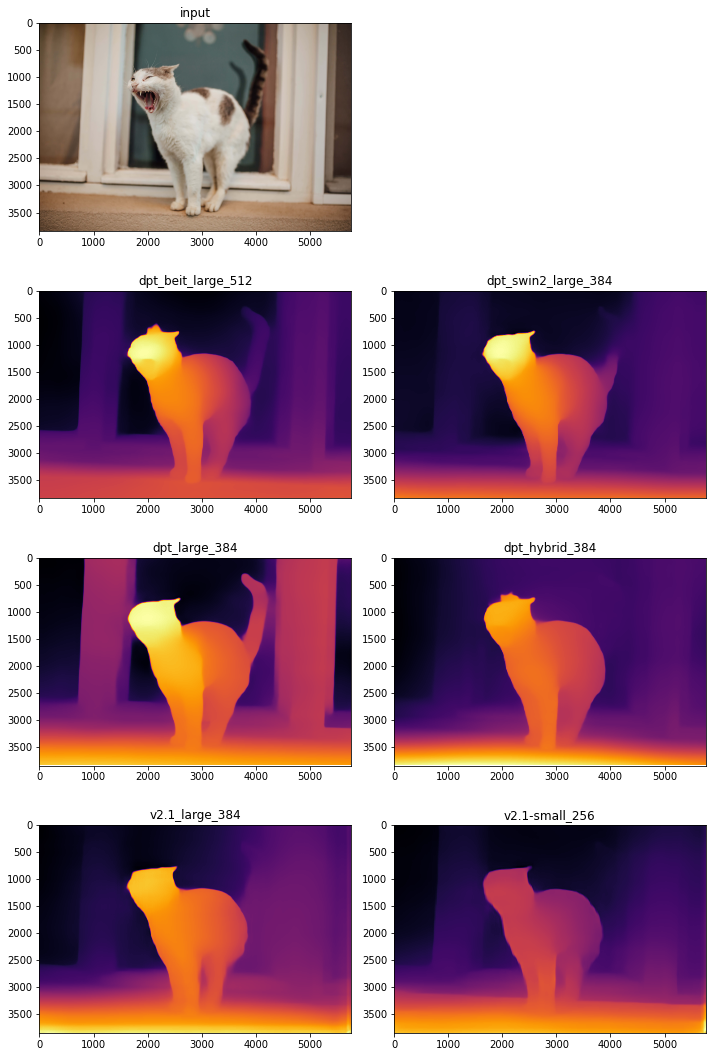

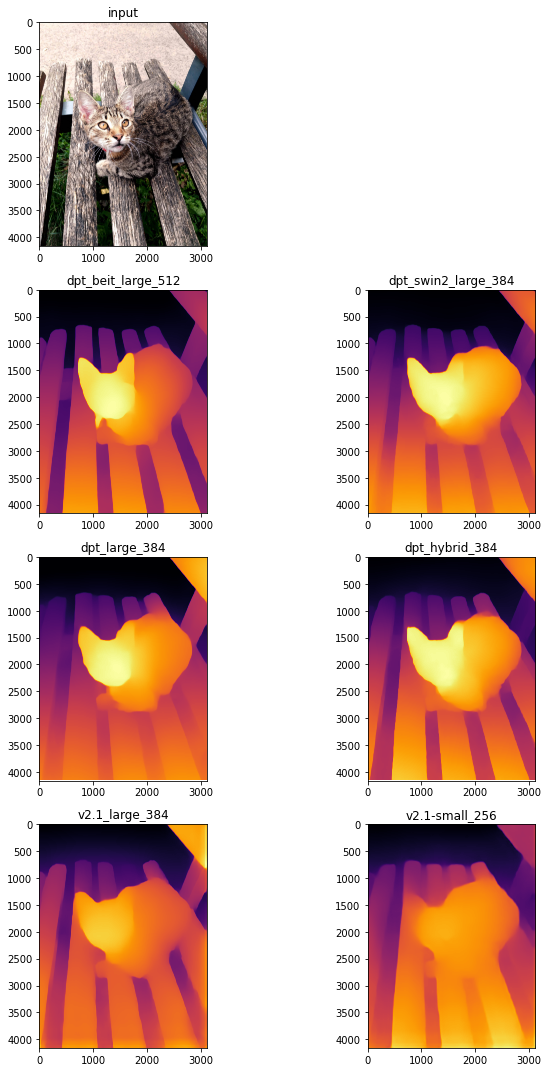

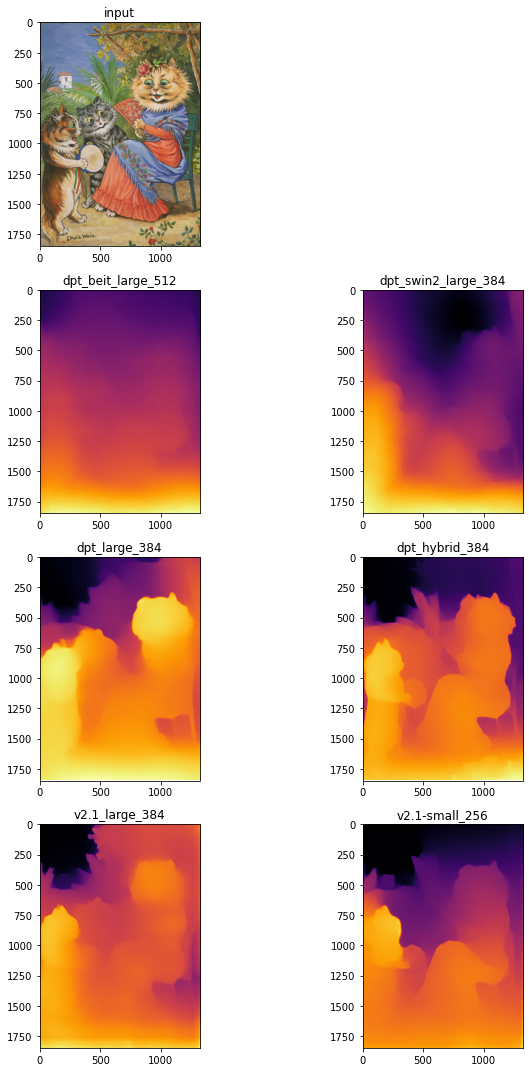

In [9]:
import math
import matplotlib.pyplot as plt

altered_modelnames = [model.modelname for model in models]

count = len(models)
col = 2
row = math.ceil(count/2) + 1 #orig image in the first row

resize = True

def plot(i, im, title): #i starts with 1, a la `plt.subplot`
	x = i % 2
	y = i // 2
	ax = axs[y][x]

	ax.imshow(im, cmap="inferno")
	ax.set_title(title)

for image in images:
	fig, axs = plt.subplots(row, col, figsize=(10, 15))
	fig.delaxes(axs[0][1])

	orig_img = as_input(image)
	plot(0, orig_img, "input")

	outputs_im = outputs[image]
	for modelname, output in outputs_im.items():
		to_plot = output
		if resize:
			to_plot = cv2.resize(to_plot, orig_img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

		idx = altered_modelnames.index(modelname)
		plot(2+idx, to_plot, modelname)

	plt.tight_layout()
	plt.show()